In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output

from prettytable import PrettyTable, TableStyle
from scipy.stats import skew

# Data Analysis Begins

- Load data

In [3]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    """
    Load a dataset based on the specified time range.

    This function reads an Excel file containing the dataset for the specified time range
    and returns it as a pandas DataFrame. Two options are currently available:
    "1985-2023" or "2010-2023".

    Args:
        option (str, optional): A string indicating the time range for the dataset.
            Defaults to "1985-2023".
            - "1985-2023": Loads data from 'tentative_final_with_NaN.xlsx'.
            - "2010-2023": Loads data from 'tentative_final.xlsx'.

    Returns:
        pd.DataFrame: A DataFrame containing the dataset for the specified time range.

    Raises:
        FileNotFoundError: If the specified Excel file is not found.
        ValueError: If an invalid option is provided.

    Example:
        >>> df = load_data(option="2010-2023")
        >>> print(df.head())
    """
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    elif option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    else:
        raise ValueError("Invalid option. Choose either '1985-2023' or '2010-2023'.")
    return df

### Load and view data

In [4]:
tentative_df = load_data(option="1985-2023")
tentative_df

County  Year  Population  crime_rate  clearance_rate  \
0     Alameda  1985     1185500    0.009809        0.004580   
1     Alameda  1986     1206900    0.010353        0.004615   
2     Alameda  1987     1220600    0.009588        0.005164   
3     Alameda  1988     1242300    0.008825        0.004595   
4     Alameda  1989     1261200    0.008375        0.004163   
...       ...   ...         ...         ...             ...   
2257     Yuba  2019       79619    0.004095        0.001683   
2258     Yuba  2020       81178    0.004977        0.001983   
2259     Yuba  2021       82091    0.004312        0.001815   
2260     Yuba  2022       82563    0.003379        0.001466   
2261     Yuba  2023       83405    0.004005        0.001463   

      population_density  unemployment_rate  adjusted_income  poverty_rate  \
0            1606.368564                NaN              NaN           NaN   
1            1635.365854                NaN              NaN           NaN   
2            1653.929539                NaN              NaN           NaN   
3            1683.333333                NaN              NaN           NaN   
4            1708.943089                NaN              NaN           NaN   
...                  ...                ...              ...           ...   
2257          126.379365                6.2       201.708250          15.2   
2258          128.853968               10.6       197.248655          16.3   
2259          130.303175                8.4       204.337343          15.6   
2260          131.052381                5.6       199.314588          14.9   
2261          132.388889                6.7       215.467565          15.4   

      rent_burden  ...  adj_prison_budget  median_house_value  \
0             NaN  ...                NaN                 NaN   
1             NaN  ...                NaN                 NaN   
2             NaN  ...                NaN                 NaN   
3             NaN  ...                NaN                 NaN   
4             NaN  ...                NaN                 NaN   
...           ...  ...                ...                 ...   
2257         41.5  ...           1.290150            257100.0   
2258         37.5  ...           1.278197            273600.0   
2259         39.3  ...           1.338206            286000.0   
2260         39.5  ...           1.309347            350600.0   
2261         38.8  ...           1.359282            380000.0   

      house_affordability  Category  Category_encoded  Category_Rural  \
0                     NaN     Urban                 2               0   
1                     NaN     Urban                 2               0   
2                     NaN     Urban                 2               0   
3                     NaN     Urban                 2               0   
4                     NaN     Urban                 2               0   
...                   ...       ...               ...             ...   
2257             4.541841     Rural                 0               1   
2258             4.861580     Rural                 0               1   
2259             4.706734     Rural                 0               1   
2260             5.510326     Rural                 0               1   
2261             5.315206     Rural                 0               1   

      Category_Suburban  Category_Urban  uninsured_rate  high_school_rate  
0                     0               1             NaN               NaN  
1                     0               1             NaN               NaN  
2                     0               1             NaN               NaN  
3                     0               1             NaN               NaN  
4                     0               1             NaN               NaN  
...                 ...             ...             ...               ...  
2257                  0               0        0.072427              82.3  
2258                  0               0        

In [5]:
tentative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262 entries, 0 to 2261
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   County                        2262 non-null   object 
 1   Year                          2262 non-null   int64  
 2   Population                    2262 non-null   int64  
 3   crime_rate                    2262 non-null   float64
 4   clearance_rate                2262 non-null   float64
 5   population_density            2262 non-null   float64
 6   unemployment_rate             1914 non-null   float64
 7   adjusted_income               928 non-null    float64
 8   poverty_rate                  870 non-null    float64
 9   rent_burden                   812 non-null    float64
 10  home_ownership_rate           812 non-null    float64
 11  mobile_home_ratio             812 non-null    float64
 12  vacancy_rate                  812 non-null    float64
 13  Tot

In [6]:
def add_new_features(df: pd.DataFrame, features: dict) -> pd.DataFrame:
    """
    Add new features (columns) to a given DataFrame.

    This function takes an existing DataFrame and a dictionary of features,
    where keys are column names and values are the data to be added. It creates
    a copy of the original DataFrame, adds the new features to it, and returns
    the updated DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to which new features will be added.
        features (dict): A dictionary where:
            - Keys are the names of the new columns to be added.
            - Values are the data for each corresponding column (as lists or arrays).

    Returns:
        pd.DataFrame: A new DataFrame with the added features.

    Example:
        >>> df = pd.DataFrame({"A": [1, 2, 3]})
        >>> features = {"B": [4, 5, 6], "C": [7, 8, 9]}
        >>> new_df = add_new_features(df, features)
        >>> print(new_df)
           A  B  C
        0  1  4  7
        1  2  5  8
        2  3  6  9
    """
    new_df = df.copy()
    for key, val in features.items():
        new_df[key] = val
    return new_df

In [7]:
def choose_dataframe(df, option, new_features: dict) -> tuple[pd.DataFrame, list]:
    """
    Choose between the original DataFrame or an updated version with new features.

    This function takes an existing DataFrame, an option specifying whether to add
    new features, and a dictionary of new features. If the option is "new", the function
    adds the new features to a copy of the DataFrame and returns it, along with a list
    of the new feature names. If the option is not "new", it returns the original DataFrame
    and an empty list.

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.
        option (str): Specifies the operation to perform.
            - "new": Adds new features to the DataFrame.
            - Any other value: Returns the original DataFrame unchanged.
        new_features (dict): A dictionary where:
            - Keys are the names of the new columns to be added.
            - Values are the data for each corresponding column.

    Returns:
        tuple[pd.DataFrame, list]:
            - The first element is a DataFrame (either updated or original).
            - The second element is a list of added feature names (empty if no new features are added).

    Example:
        >>> df = pd.DataFrame({"A": [1, 2, 3]})
        >>> new_features = {"B": [4, 5, 6], "C": [7, 8, 9]}
        >>> updated_df, feature_names = choose_dataframe(df, "new", new_features)
        >>> print(updated_df)
           A  B  C
        0  1  4  7
        1  2  5  8
        2  3  6  9
        >>> print(feature_names)
        ['B', 'C']

        >>> original_df, feature_names = choose_dataframe(df, "original", new_features)
        >>> print(original_df)
           A
        >>> print(feature_names)
        []
    """
    df = df.copy()
    if option == "new":
        return add_new_features(df, new_features), list(new_features.keys())
    return df, []

### Sort dataframe  by ["County", "Year"]

In [8]:
tentative_df = tentative_df.sort_values(by=["County", "Year"])

#### New features

In [9]:
# Weights can be adjusted
weights = {"unemployment_rate": 0.5, "poverty_rate": 0.3, "rent_burden": 0.2}
new_features = {
    # "prev_crime_rate_1": tentative_df.groupby("County")["crime_rate"].shift(1),
    # "prev_crime_rate_2": tentative_df.groupby("County")["crime_rate"].shift(2),
    "police_budget_per_capita": tentative_df["police_budget"]
    / tentative_df["Population"],
    "education_budget_per_capita": tentative_df["education_budget"]
    / tentative_df["Population"],
    "welfare_budget_per_capita": tentative_df["welfare_budget"]
    / tentative_df["Population"],
    "mental_health_budget_per_capita": tentative_df["mental_health_budget"]
    / tentative_df["Population"],
    "rehab_budget_per_capita": tentative_df["rehab_budget"]
    / tentative_df["Population"],
    "health_budget_per_capita": tentative_df["health_budget"]
    / tentative_df["Population"],
    "judiciary_budget_per_capita": tentative_df["judiciary_budget"]
    / tentative_df["Population"],
    "prison_budget_per_capita": tentative_df["prison_budget"]
    / tentative_df["Population"],
    "combined_adj_budgets": tentative_df["adj_police_budget"]
    + tentative_df["adj_education_budget"]
    + tentative_df["adj_welfare_budget"]
    + tentative_df["adj_mental_health_budget"]
    + tentative_df["rehab_budget"]
    + tentative_df["adj_health_budget"]
    + tentative_df["judiciary_budget"]
    + tentative_df["prison_budget"],
    "stress_factor": (
        tentative_df["unemployment_rate"] * weights["unemployment_rate"]
        + tentative_df["poverty_rate"] * weights["poverty_rate"]
        + tentative_df["rent_burden"] * weights["rent_burden"]
    ),
}

### new: Add new features, old: no new features added.

In [10]:
new_old_df, added_features = choose_dataframe(tentative_df, "old", new_features)
crime_dataframe = new_old_df.copy()
df = new_old_df.copy()

In [11]:
added_features

[]

## Use ColumnTransformer and SimpleImputer to replace NaN with some data.

In [ ]:
def detect_imputation_strategy(dataframe, threshold=0.5):
    """
    Categorize columns for imputation based on their data type and missing values.

    Args:
        dataframe (pd.DataFrame): Dataset to analyze.
        threshold (float, optional): Skewness threshold for distinguishing
                                     mean vs. median imputation (default: 0.5).

    Returns:
        dict: Contains column categorization:
            - 'mean': Columns suitable for mean imputation.
            - 'median': Columns suitable for median imputation.
            - 'untouched': Columns left unchanged, including string columns and
                           numeric columns without missing values.

    Example:
        >>> df = pd.DataFrame({
        ...     "feature1": [1, 2, 3, np.nan],
        ...     "feature2": [1, 100, 2, np.nan],
        ...     "feature3": [5, 5, 5, 5],
        ...     "feature4": ["a", "b", "c", "d"]
        ... })
        >>> strategies = detect_imputation_strategy(df)
        >>> print(strategies)

    Notes:
        - Skewness is computed for numeric columns with missing values.
        - String columns are always left unchanged.
    """
    mean_columns = []
    median_columns = []
    untouched_columns = []

    for column in dataframe.columns:
        if dataframe[column].dtype in [np.float64, np.int64]:  # Numeric columns
            if dataframe[column].isnull().any():
                col_skewness = skew(dataframe[column].dropna())
                if abs(col_skewness) <= threshold:
                    mean_columns.append(column)
                else:
                    median_columns.append(column)
            else:
                untouched_columns.append(column)
        elif dataframe[column].dtype == object:  # String columns
            untouched_columns.append(column)

    return {
        "mean": mean_columns,
        "median": median_columns,
        "untouched": untouched_columns,
    }


# Detect columns for mean, median, and untouched
strategies = detect_imputation_strategy(crime_dataframe)

print("Columns for mean imputation:", strategies["mean"])
print("Columns for median imputation:", strategies["median"])
print("Untouched columns:", strategies["untouched"])

Columns for mean imputation: ['poverty_rate', 'home_ownership_rate', 'Number_of_Persons_per_HseHld']
Columns for median imputation: ['unemployment_rate', 'adjusted_income', 'rent_burden', 'mobile_home_ratio', 'vacancy_rate', 'Total_Persons_Owner', 'Total_Persons_Renter', 'Total_Persons', 'median_age', 'police_budget', 'education_budget', 'welfare_budget', 'mental_health_budget', 'rehab_budget', 'health_budget', 'judiciary_budget', 'prison_budget', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value', 'house_affordability', 'uninsured_rate', 'high_school_rate']
Untouched columns: ['County', 'Year', 'Population', 'crime_rate', 'clearance_rate', 'population_density', 'Category', 'Category_encoded', 'Category_Rural', 'Category_Suburban', 'Category_Urban']


In [13]:
crime_dataframe

County  Year  Population  crime_rate  clearance_rate  \
0     Alameda  1985     1185500    0.009809        0.004580   
1     Alameda  1986     1206900    0.010353        0.004615   
2     Alameda  1987     1220600    0.009588        0.005164   
3     Alameda  1988     1242300    0.008825        0.004595   
4     Alameda  1989     1261200    0.008375        0.004163   
...       ...   ...         ...         ...             ...   
2257     Yuba  2019       79619    0.004095        0.001683   
2258     Yuba  2020       81178    0.004977        0.001983   
2259     Yuba  2021       82091    0.004312        0.001815   
2260     Yuba  2022       82563    0.003379        0.001466   
2261     Yuba  2023       83405    0.004005        0.001463   

      population_density  unemployment_rate  adjusted_income  poverty_rate  \
0            1606.368564                NaN              NaN           NaN   
1            1635.365854                NaN              NaN           NaN   
2            1653.929539                NaN              NaN           NaN   
3            1683.333333                NaN              NaN           NaN   
4            1708.943089                NaN              NaN           NaN   
...                  ...                ...              ...           ...   
2257          126.379365                6.2       201.708250          15.2   
2258          128.853968               10.6       197.248655          16.3   
2259          130.303175                8.4       204.337343          15.6   
2260          131.052381                5.6       199.314588          14.9   
2261          132.388889                6.7       215.467565          15.4   

      rent_burden  ...  adj_prison_budget  median_house_value  \
0             NaN  ...                NaN                 NaN   
1             NaN  ...                NaN                 NaN   
2             NaN  ...                NaN                 NaN   
3             NaN  ...                NaN                 NaN   
4             NaN  ...                NaN                 NaN   
...           ...  ...                ...                 ...   
2257         41.5  ...           1.290150            257100.0   
2258         37.5  ...           1.278197            273600.0   
2259         39.3  ...           1.338206            286000.0   
2260         39.5  ...           1.309347            350600.0   
2261         38.8  ...           1.359282            380000.0   

      house_affordability  Category  Category_encoded  Category_Rural  \
0                     NaN     Urban                 2               0   
1                     NaN     Urban                 2               0   
2                     NaN     Urban                 2               0   
3                     NaN     Urban                 2               0   
4                     NaN     Urban                 2               0   
...                   ...       ...               ...             ...   
2257             4.541841     Rural                 0               1   
2258             4.861580     Rural                 0               1   
2259             4.706734     Rural                 0               1   
2260             5.510326     Rural                 0               1   
2261             5.315206     Rural                 0               1   

      Category_Suburban  Category_Urban  uninsured_rate  high_school_rate  
0                     0               1             NaN               NaN  
1                     0               1             NaN               NaN  
2                     0               1             NaN               NaN  
3                     0               1             NaN               NaN  
4                     0               1             NaN               NaN  
...                 ...             ...             ...               ...  
2257                  0               0        0.072427              82.3  
2258                  0               0        

In [14]:
def create_transformer(strategy, columns):
    """
    Create a transformer pipeline for a specific strategy (e.g., 'mean', 'median').

    Args:
        strategy (str): Imputation strategy ('mean' or 'median').
        columns (list): List of columns to apply the transformation to.

    Returns:
        tuple: A named transformer for the ColumnTransformer.
    """
    transformer = Pipeline([("imputer", SimpleImputer(strategy=strategy))])
    return (strategy, transformer, columns)


def preprocess_data(dataframe, column_groups):
    """
    Apply preprocessing to the given DataFrame.

    Args:
        dataframe (pd.DataFrame): Input DataFrame.
        column_groups (dict): A dictionary where the key is the strategy (e.g., 'mean')
                              and the value is a list of columns for that strategy.

    Returns:
        pd.DataFrame: Preprocessed DataFrame with untouched columns added back.
    """
    untouched_columns = column_groups.pop("untouched", [])

    # Create transformers for each group
    transformers = [
        create_transformer(strategy, columns)
        for strategy, columns in column_groups.items()
    ]

    # Combine transformations into a ColumnTransformer
    preprocessor = ColumnTransformer(transformers)

    # Apply transformation
    transformed_data = preprocessor.fit_transform(dataframe)

    # Convert back to a DataFrame
    transformed_df = pd.DataFrame(
        transformed_data,
        columns=[col for cols in column_groups.values() for col in cols],
    )

    # Add untouched columns back
    return pd.concat(
        [dataframe[untouched_columns].reset_index(drop=True), transformed_df], axis=1
    )

#### Get a clean dataframe

In [15]:
column_groups = strategies
clean_dataframe = preprocess_data(crime_dataframe, column_groups)

#### View cleaned dataframe info

In [16]:
clean_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262 entries, 0 to 2261
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   County                        2262 non-null   object 
 1   Year                          2262 non-null   int64  
 2   Population                    2262 non-null   int64  
 3   crime_rate                    2262 non-null   float64
 4   clearance_rate                2262 non-null   float64
 5   population_density            2262 non-null   float64
 6   Category                      2262 non-null   object 
 7   Category_encoded              2262 non-null   int64  
 8   Category_Rural                2262 non-null   int64  
 9   Category_Suburban             2262 non-null   int64  
 10  Category_Urban                2262 non-null   int64  
 11  poverty_rate                  2262 non-null   float64
 12  home_ownership_rate           2262 non-null   float64
 13  Num

In [17]:
final_dataframe = clean_dataframe.copy()
final_dataframe = final_dataframe.set_index(["County", "Year"])

### Dependent and Independent variables

In [18]:
target = ["crime_rate"]
features = [
    "Population",
    "clearance_rate",
    "population_density",
    "mobile_home_ratio",
    "poverty_rate",
    "adjusted_income",
    "unemployment_rate",
    "high_school_rate",
    "uninsured_rate",
    "house_affordability",
    "adj_police_budget",
    "adj_education_budget",
    "adj_welfare_budget",
    "adj_mental_health_budget",
    "adj_rehab_budget",
    "adj_health_budget",
    "adj_judiciary_budget",
    "adj_prison_budget",
    "home_ownership_rate",
    "rent_burden",
] + added_features

### Dataframe to work with

In [19]:
final_dataframe = final_dataframe[target + features]
final_dataframe

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.004580         1606.368564   
        1986    0.010353     1206900        0.004615         1635.365854   
        1987    0.009588     1220600        0.005164         1653.929539   
        1988    0.008825     1242300        0.004595         1683.333333   
        1989    0.008375     1261200        0.004163         1708.943089   
...                  ...         ...             ...                 ...   
Yuba    2019    0.004095       79619        0.001683          126.379365   
        2020    0.004977       81178        0.001983          128.853968   
        2021    0.004312       82091        0.001815          130.303175   
        2022    0.003379       82563        0.001466          131.052381   
        2023    0.004005       83405        0.001463          132.388889   

              mobile_home_ratio  poverty_rate  adjusted_income  \
County  Year                                                     
Alameda 1985           0.061794     14.975287       219.856018   
        1986           0.061794     14.975287       219.856018   
        1987           0.061794     14.975287       219.856018   
        1988           0.061794     14.975287       219.856018   
        1989           0.061794     14.975287       219.856018   
...                         ...           ...              ...   
Yuba    2019           0.082943     15.200000       201.708250   
        2020           0.093497     16.300000       197.248655   
        2021           0.087198     15.600000       204.337343   
        2022           0.083845     14.900000       199.314588   
        2023           0.080927     15.400000       215.467565   

              unemployment_rate  high_school_rate  uninsured_rate  ...  \
County  Year                                                       ...   
Alameda 1985               7.85             85.55        0.099819  ...   
        1986               7.85             85.55        0.099819  ...   
        1987               7.85             85.55        0.099819  ...   
        1988               7.85             85.55        0.099819  ...   
        1989               7.85             85.55        0.099819  ...   
...                         ...               ...             ...  ...   
Yuba    2019               6.20             82.30        0.072427  ...   
        2020              10.60             82.20        0.071218  ...   
        2021               8.40             81.20        0.070699  ...   
        2022               5.60             82.70        0.069229  ...   
        2023               6.70             84.70        0.068728  ...   

              adj_police_budget  adj_education_budget  adj_welfare_budget  \
County  Year                                                                
Alameda 1985           0.612416              0.062861            1.770601   
        1986           0.612416              0.062861            1.770601   
        1987           0.612416              0.062861            1.770601   
        1988           0.612416              0.062861            1.770601   
        1989           0.612416              0.062861            1.770601   
...                         ...                   ...                 ...   
Yuba    2019           0.658646              0.033616            2.478681   
        2020           0.765412              0.039940            2.638903   
        2021           0.806008              0.030682            2.530132   
        2022           0.788031              0.033300            2.457424   
        2023           0.924042              0.041942            2.773449   

              adj_mental_health_budget  adj_rehab_budget  adj_health_budget  \
County  Year                                                                  
Alameda 1985                  0.651314     

In [20]:
print(final_dataframe.isnull().sum())  # For pandas DataFrame
print(np.isnan(final_dataframe).sum())  # For numpy array
print(np.isinf(final_dataframe).sum())  # Check for infinite values

crime_rate                  0
Population                  0
clearance_rate              0
population_density          0
mobile_home_ratio           0
poverty_rate                0
adjusted_income             0
unemployment_rate           0
high_school_rate            0
uninsured_rate              0
house_affordability         0
adj_police_budget           0
adj_education_budget        0
adj_welfare_budget          0
adj_mental_health_budget    0
adj_rehab_budget            0
adj_health_budget           0
adj_judiciary_budget        0
adj_prison_budget           0
home_ownership_rate         0
rent_burden                 0
dtype: int64
crime_rate                  0
Population                  0
clearance_rate              0
population_density          0
mobile_home_ratio           0
poverty_rate                0
adjusted_income             0
unemployment_rate           0
high_school_rate            0
uninsured_rate              0
house_affordability         0
adj_police_budget          

### The correlation matrix. 
This determines which variables are corrrelated. It helps in feature selection.

In [21]:
correlation_matrix = final_dataframe.corr()
correlation_matrix

crime_rate  Population  clearance_rate  \
crime_rate                  1.000000    0.203885        0.800376   
Population                  0.203885    1.000000        0.072580   
clearance_rate              0.800376    0.072580        1.000000   
population_density          0.246398    0.208813        0.007162   
mobile_home_ratio          -0.007782   -0.194222        0.087403   
poverty_rate                0.131874   -0.053543        0.154600   
adjusted_income            -0.147865    0.160477       -0.216772   
unemployment_rate           0.080541   -0.144736        0.113491   
high_school_rate            0.052175   -0.029761        0.035451   
uninsured_rate             -0.049863    0.071066       -0.023261   
house_affordability        -0.086830    0.170899       -0.130845   
adj_police_budget           0.077534   -0.058788        0.015735   
adj_education_budget        0.094322   -0.064110        0.028344   
adj_welfare_budget          0.133410   -0.036331        0.077773   
adj_mental_health_budget    0.084685   -0.078585        0.041918   
adj_rehab_budget            0.073299   -0.065602        0.016467   
adj_health_budget           0.070604   -0.066934        0.011586   
adj_judiciary_budget        0.044816   -0.037765        0.022213   
adj_prison_budget           0.009276   -0.147049        0.013292   
home_ownership_rate        -0.056266   -0.244270        0.015957   
rent_burden                -0.029096    0.087519        0.008857   

                          population_density  mobile_home_ratio  poverty_rate  \
crime_rate                          0.246398          -0.007782      0.131874   
Population                          0.208813          -0.194222     -0.053543   
clearance_rate                      0.007162           0.087403      0.154600   
population_density                  1.000000          -0.182785     -0.119282   
mobile_home_ratio                  -0.182785           1.000000      0.382622   
poverty_rate                       -0.119282           0.382622      1.000000   
adjusted_income                     0.264491          -0.533047     -0.735736   
unemployment_rate                  -0.173366           0.113279      0.367508   
high_school_rate                    0.028706          -0.060187     -0.327109   
uninsured_rate                     -0.075684           0.097951      0.524029   
house_affordability                 0.258239          -0.280787     -0.363840   
adj_police_budget                  -0.038426          -0.019645     -0.011702   
adj_education_budget               -0.033462          -0.082944      0.007208   
adj_welfare_budget                 -0.058506           0.299080      0.460863   
adj_mental_health_budget           -0.040725           0.067840      0.040301   
adj_rehab_budget                   -0.037070           0.033890      0.031974   
adj_health_budget                  -0.036919           0.026854     -0.011118   
adj_judiciary_budget               -0.028669           0.114839     -0.043851   
adj_prison_budget                  -0.066894           0.420326     -0.035009   
home_ownership_rate                -0.302626           0.294869     -0.147514   
rent_burden                        -0.132904           0.061896      0.274030   

                          adjusted_income  unemployment_rate  \
crime_rate                      -0.147865           0.080541   
Population                       0.160477          -0.144736   
clearance_rate                  -0.216772           0.113491   
population_density               0.264491          -0.173366   
mobile_home_ratio               -0.533047           0.113279   
poverty_rate                    -0.735736           0.367508   
adjusted_income                  1.000000          -0.328848   
unemployment_rate               -0.328848           1.000000   
high_school_rate                 0.139892          -0.221377   
uninsured_rate                  -0.340623           0.363871   
house_affordability              0.530080 

### A seaborn heatmap showing correlation amongst the variables.

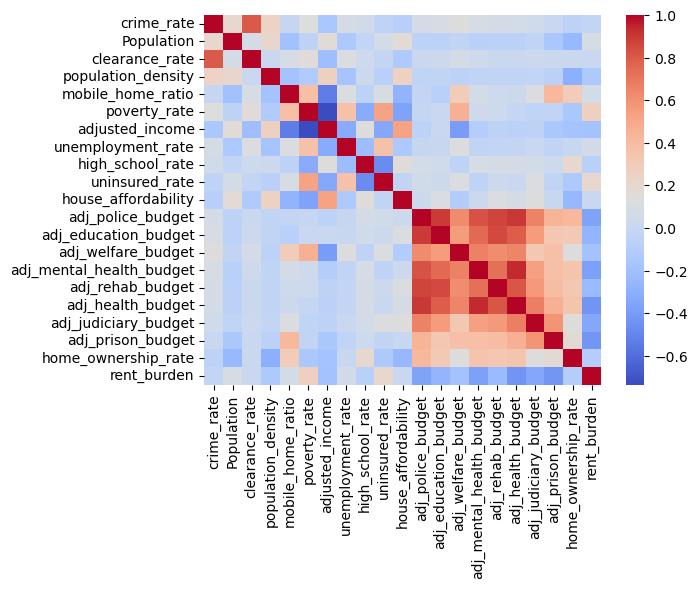

In [22]:
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.show()

### A seabon clustermap

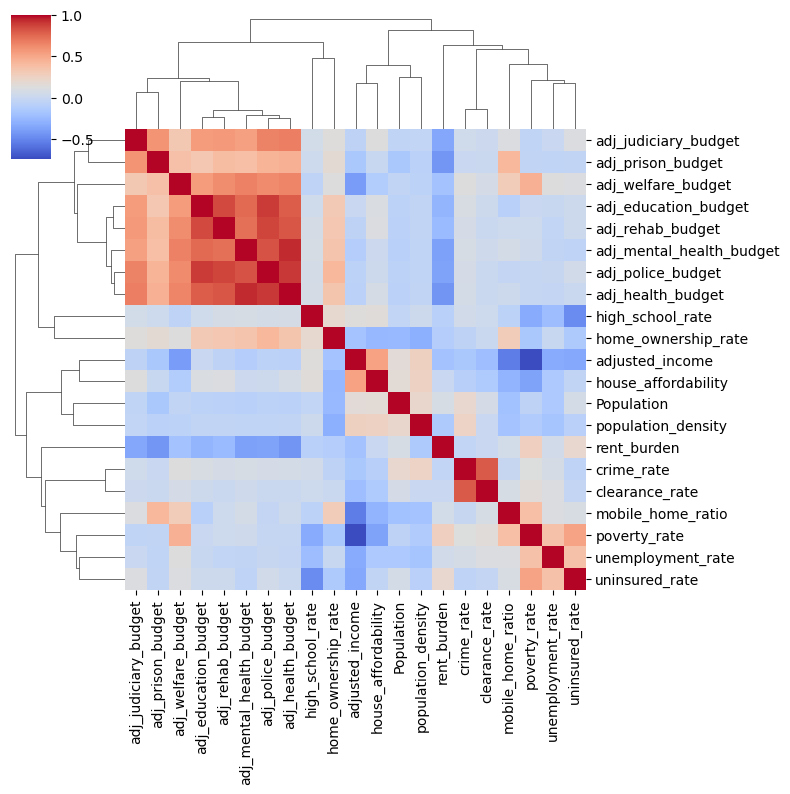

In [23]:
# Create a clustermap
sns.clustermap(correlation_matrix, cmap="coolwarm", figsize=(8, 8))
plt.show()

### A network graph visualizing the correlation 

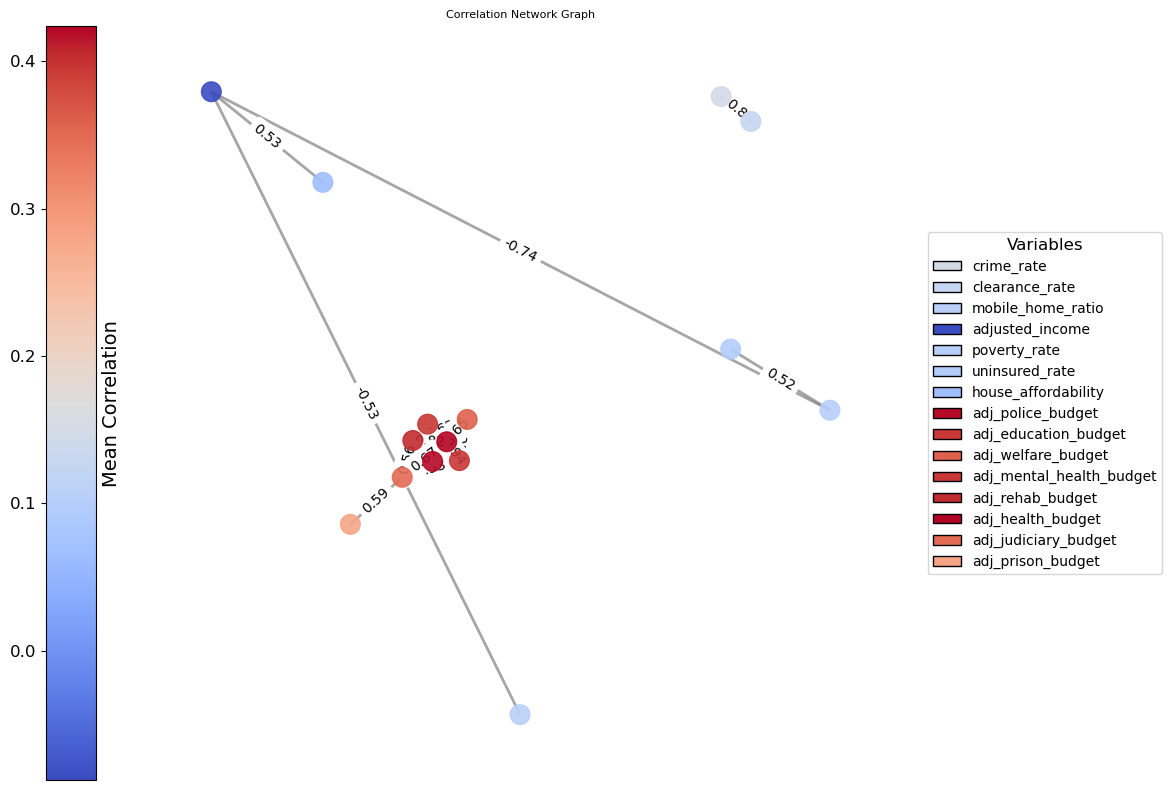

In [24]:
# Create a network graph
G = nx.Graph()

# Add nodes and edges based on correlation threshold
threshold = 0.5

"""
for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            # Add weighted edges
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])
"""
# Ensure the correlation matrix is square
if not correlation_matrix.columns.equals(correlation_matrix.index):
    raise ValueError("The correlation matrix must have identical rows and columns.")


# Fill NaNs (if needed) and iterate
# correlation_matrix = correlation_matrix.fillna(0)

for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        # print(correlation_matrix.loc[i, j])

        # Ensure i != j and add edges based on the threshold
        if i != j and abs(correlation_matrix.at[i, j]) > threshold:
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])


# Filter the node_colors to include only the nodes present in the graph
graph_nodes = list(G.nodes)
node_colors = correlation_matrix.loc[graph_nodes, graph_nodes].mean(
    axis=0
)  # Compute mean only for graph nodes
norm = mcolors.Normalize(
    vmin=node_colors.min(), vmax=node_colors.max()
)  # Normalize for color mapping
cmap = plt.cm.coolwarm  # Colormap for the nodes
node_colors_mapped = [
    cmap(norm(value)) for value in node_colors
]  # Map values to colors

# Layout for nodes
pos = nx.spring_layout(G, seed=42)  # Force-directed layout for better spacing

# Start the plot with customized figure layout
fig = plt.figure(figsize=(12, 8))
grid = fig.add_gridspec(
    1, 3, width_ratios=[0.05, 0.75, 0.2]
)  # Adjust width_ratios for a thinner cbar
ax_cbar = fig.add_subplot(grid[0])  # Color bar on the left
ax_main = fig.add_subplot(grid[1])  # Main graph in the center
ax_legend = fig.add_subplot(grid[2])  # Legend on the right

# Draw the main graph
nx.draw_networkx_nodes(
    G, pos, node_size=200, node_color=node_colors_mapped, alpha=0.9, ax=ax_main
)
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", alpha=0.7, ax=ax_main)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): round(d["weight"], 2) for u, v, d in G.edges(data=True)},
    font_size=10,
    font_color="black",
    ax=ax_main,
)
ax_main.set_title(
    "Correlation Network Graph",
    fontsize=8,
)
ax_main.axis("off")  # Hide axis for the graph

# Add resized color bar with larger fonts
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_cbar, orientation="vertical")
cbar.ax.tick_params(labelsize=12)  # Increase tick label font size
cbar.set_label("Mean Correlation", fontsize=14)  # Increase color bar label font size
ax_cbar.yaxis.tick_left()

# Create a legend on the right
ax_legend.axis("off")  # Hide the axes for the legend panel
legend_elements = [
    Patch(facecolor=cmap(norm(value)), edgecolor="black", label=f"{node}")
    for node, value in zip(graph_nodes, node_colors)
]
ax_legend.legend(
    handles=legend_elements,
    loc="center",
    title="Variables",
    fontsize=10,
    title_fontsize=12,
)

# Finalize the layout
plt.tight_layout()
plt.show()

In [25]:
clean_dataframe

County  Year  Population  crime_rate  clearance_rate  \
0     Alameda  1985     1185500    0.009809        0.004580   
1     Alameda  1986     1206900    0.010353        0.004615   
2     Alameda  1987     1220600    0.009588        0.005164   
3     Alameda  1988     1242300    0.008825        0.004595   
4     Alameda  1989     1261200    0.008375        0.004163   
...       ...   ...         ...         ...             ...   
2257     Yuba  2019       79619    0.004095        0.001683   
2258     Yuba  2020       81178    0.004977        0.001983   
2259     Yuba  2021       82091    0.004312        0.001815   
2260     Yuba  2022       82563    0.003379        0.001466   
2261     Yuba  2023       83405    0.004005        0.001463   

      population_density Category  Category_encoded  Category_Rural  \
0            1606.368564    Urban                 2               0   
1            1635.365854    Urban                 2               0   
2            1653.929539    Urban                 2               0   
3            1683.333333    Urban                 2               0   
4            1708.943089    Urban                 2               0   
...                  ...      ...               ...             ...   
2257          126.379365    Rural                 0               1   
2258          128.853968    Rural                 0               1   
2259          130.303175    Rural                 0               1   
2260          131.052381    Rural                 0               1   
2261          132.388889    Rural                 0               1   

      Category_Suburban  ...  adj_welfare_budget  adj_mental_health_budget  \
0                     0  ...            1.770601                  0.651314   
1                     0  ...            1.770601                  0.651314   
2                     0  ...            1.770601                  0.651314   
3                     0  ...            1.770601                  0.651314   
4                     0  ...            1.770601                  0.651314   
...                 ...  ...                 ...                       ...   
2257                  0  ...            2.478681                  0.651314   
2258                  0  ...            2.638903                  0.651314   
2259                  0  ...            2.530132                  0.651314   
2260                  0  ...            2.457424                  0.651314   
2261                  0  ...            2.773449                  0.651314   

      adj_rehab_budget  adj_health_budget  adj_judiciary_budget  \
0             0.085242           1.198341              0.477970   
1             0.085242           1.198341              0.477970   
2             0.085242           1.198341              0.477970   
3             0.085242           1.198341              0.477970   
4             0.085242           1.198341              0.477970   
...                ...                ...                   ...   
2257          0.085242           0.330838              0.349174   
2258          0.085242           0.347511              0.362152   
2259          0.085242           0.368092              0.325340   
2260          0.085242           0.310002              0.305015   
2261          0.085242           0.372200              0.326688   

      adj_prison_budget  median_house_value  house_affordability  \
0              0.692515            326050.0             5.517035   
1              0.692515            326050.0             5.517035   
2              0.692515            326050.0             5.517035   
3              0.692515            326050.0             5.517035   
4              0.692515            326050.0             5.517035   
...                 ...                 ...                  ...   
2257           1.290150            257100.0             4.541841   
2258           1.278197            273600.0             4.861580   
2259           1.338206            286000.0

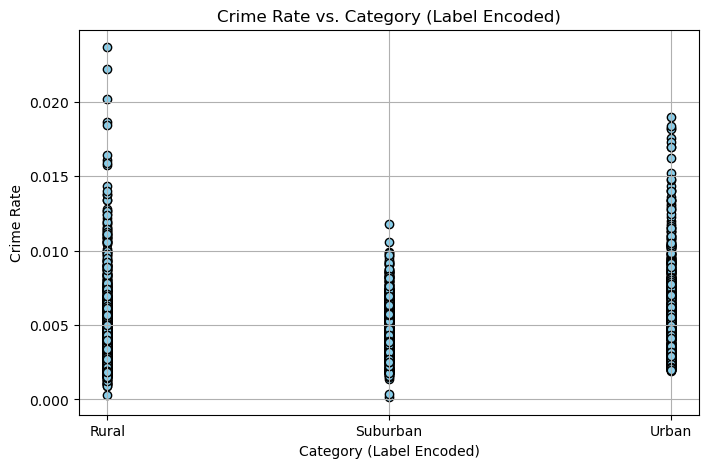

In [26]:
# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(
    clean_dataframe["Category_encoded"],
    clean_dataframe["crime_rate"],
    color="skyblue",
    edgecolor="black",
)
plt.xticks([0, 1, 2], ["Rural", "Suburban", "Urban"])
plt.xlabel("Category (Label Encoded)")
plt.ylabel("Crime Rate")
plt.title("Crime Rate vs. Category (Label Encoded)")
plt.grid(True)
plt.show()

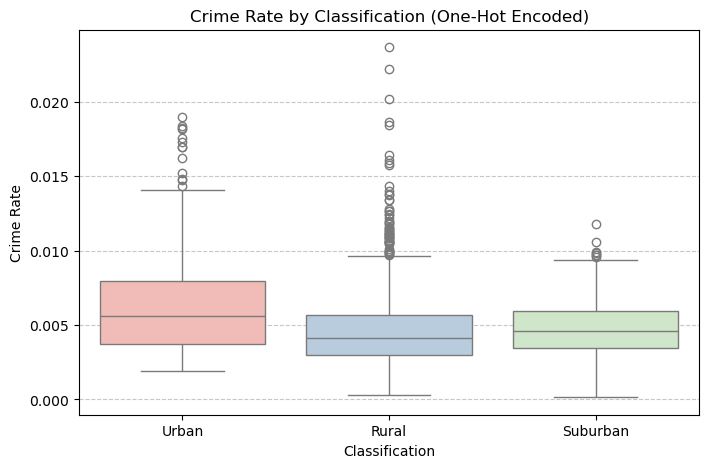

In [27]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Category", y="crime_rate", data=clean_dataframe, palette="Pastel1")
plt.title("Crime Rate by Classification (One-Hot Encoded)")
plt.xlabel("Classification")
plt.ylabel("Crime Rate")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

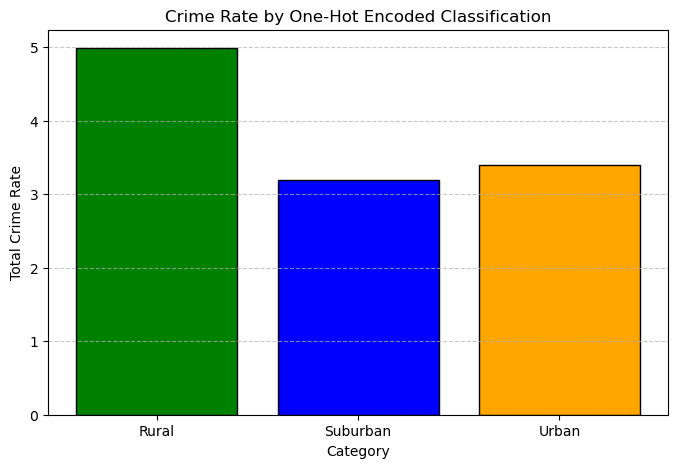

In [28]:
# Summing crime rates for each type
crime_rate_by_type = {
    "Rural": clean_dataframe["Category_Rural"].dot(clean_dataframe["crime_rate"]),
    "Suburban": clean_dataframe["Category_Suburban"].dot(clean_dataframe["crime_rate"]),
    "Urban": clean_dataframe["Category_Urban"].dot(clean_dataframe["crime_rate"]),
}

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(
    crime_rate_by_type.keys(),
    crime_rate_by_type.values(),
    color=["green", "blue", "orange"],
    edgecolor="black",
)
plt.xlabel("Category")
plt.ylabel("Total Crime Rate")
plt.title("Crime Rate by One-Hot Encoded Classification")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [29]:
# List of features for dropdown selection
feature_options = list(clean_dataframe.columns)

# Create dropdown selections for x and y axes
x_feature_dropdown = alt.binding_select(
    options=feature_options, name="Select Feature X:"
)
y_feature_dropdown = alt.binding_select(
    options=feature_options, name="Select  Feature Y:"
)
x_feature = alt.param(
    name="x_feature", bind=x_feature_dropdown, value="Population"
)  # Default X: Population
y_feature = alt.param(
    name="y_feature", bind=y_feature_dropdown, value="crime_rate"
)  # Default Y: CrimeRate

# Interactive scatter plot
scatter = (
    alt.Chart(clean_dataframe)
    .transform_calculate(
        x_value=f"datum[x_feature]",  # Dynamically calculate x-axis values
        y_value=f"datum[y_feature]",  # Dynamically calculate y-axis values
    )
    .mark_circle(size=60)
    .encode(
        x=alt.X("x_value:Q", title="X Feature"),  # Use dynamically calculated x_value
        y=alt.Y("y_value:Q", title="Y Feature"),  # Use dynamically calculated y_value
        color="Category:N",  # Color encoding by classification
        tooltip=["Population", "crime_rate", "high_school_rate", "Category"],
    )
    .add_params(x_feature, y_feature)
    .properties(width=600, height=400, title="Interactive Pairwise Scatter Plot")
    .interactive()
)

scatter

alt.Chart(...)

### Split data into train and test data

In [30]:
X = final_dataframe[features]  # Independent varaibles
y = final_dataframe["crime_rate"]  # Dependent variable

# Split data
train_data, test_data = train_test_split(
    final_dataframe, test_size=0.2, random_state=42
)
X_train, y_train = train_data[features], train_data["crime_rate"]
X_test, y_test = test_data[features], test_data["crime_rate"]

#### Ensure split ratio is accurate.

In [31]:
# Calculate the sizes
total_rows = len(final_dataframe)
train_size = len(X_train)
test_size = len(X_test)

# Check if the split is correct
print(f"Total rows: {total_rows}")
print(f"Training rows: {train_size} ({(train_size / total_rows) * 100:.2f}%)")
print(f"Testing rows: {test_size} ({(test_size / total_rows) * 100:.2f}%)")

# Verify the split
expected_test_size = total_rows * 0.2  # 20% of total rows
print(f"Expected test size: {expected_test_size:.0f}")
print(
    f"Is the split ratio correct? {'Yes' if abs(test_size - expected_test_size) < 1 else 'No'}"
)

Total rows: 2262
Training rows: 1809 (79.97%)
Testing rows: 453 (20.03%)
Expected test size: 452
Is the split ratio correct? Yes


#### Exploratory data analysis (EDA)

In [32]:
X_train.columns

Index(['Population', 'clearance_rate', 'population_density',
       'mobile_home_ratio', 'poverty_rate', 'adjusted_income',
       'unemployment_rate', 'high_school_rate', 'uninsured_rate',
       'house_affordability', 'adj_police_budget', 'adj_education_budget',
       'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget',
       'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget',
       'home_ownership_rate', 'rent_burden'],
      dtype='object')

### Regression Analysis

In [33]:
# A function to fit models
def fit_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit multiple models and compute their evaluation metrics and predictions.

    This function trains multiple machine learning models using the provided training data,
    evaluates them on both training and testing datasets, and returns the fitted models,
    evaluation metrics, and predictions.

    Parameters:
        X_train (pd.DataFrame): The feature matrix for training data.
        X_test (pd.DataFrame): The feature matrix for testing data.
        y_train (pd.DataFrame): The target/label vector for training data.
        y_test (pd.DataFrame): The target/label vector for testing data.
        models: A dictionary of machine learning models, where keys are model names
                and values are model instances (e.g., {'model_name': model_instance}).

    Returns:
        tuple[dict, dict, dict]: A tuple containing three dictionaries:
            - Fitted Models (dict):
                A dictionary where keys are model names and values are the fitted model instances.
            - Model Statistics (dict):
                A dictionary of dictionaries where keys are model names and each inner dictionary
                contains performance metrics:
                  - 'train': [mean squared error, root mean squared error, R^2 score] on training data.
                  - 'test': [mean squared error, root mean squared error, R^2 score] on testing data.
            - Predicted Values (dict):
                A dictionary of dictionaries where keys are model names and each inner dictionary
                contains predicted values:
                  - 'train': Predictions on the training data.
                  - 'test': Predictions on the testing data.

    Metrics Calculated:
        - Mean Squared Error (MSE): Measures the average squared difference between actual and predicted values.
        - Root Mean Squared Error (RMSE): Square root of MSE, providing error in the same unit as the target variable.
        - R^2 Score: Indicates the proportion of variance explained by the model (1 is perfect fit, 0 means no fit).

    Example:
        >>> from sklearn.linear_model import LinearRegression
        >>> from sklearn.ensemble import RandomForestRegressor
        >>> X_train, X_test, y_train, y_test = ...  # Load your dataset
        >>> models = {
        ...     'LinearRegression': LinearRegression(),
        ...     'RandomForest': RandomForestRegressor()
        ... }
        >>> fitted_models, stats, predictions = fit_models(X_train, X_test, y_train, y_test, **models)
        >>> print(stats['LinearRegression'])
        {
            'train': [mse_train, rmse_train, r2_train],
            'test': [mse_test, rmse_test, r2_test]
        }
        >>> print(predictions['RandomForest']['test'])  # Predictions for testing data

    Notes:
        - Ensure that the `models` dictionary contains scikit-learn compatible estimators (i.e., with `fit()` and `predict()` methods).
        - External utility functions like `mean_squared_error`, `root_mean_squared_error`, and `r2_score` must be imported.

    Raises:
        AttributeError: If any model in `models` does not have the required methods `fit` and `predict`.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        model.fit(X_train, y_train)

        # Find the model predictions on the training set
        train_preds = model.predict(X_train)

        # Find the model predictions on the test set
        test_preds = model.predict(X_test)

        # Find the mse on the training set
        train_mse = mean_squared_error(y_train, train_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        train_r2score = r2_score(y_train, train_preds)

        # Find the mse on the test set
        test_mse = mean_squared_error(y_test, test_preds)
        test_rmse = root_mean_squared_error(y_test, test_preds)
        test_r2score = r2_score(y_test, test_preds)

        fitted_models[key] = model
        model_stats[key] = {
            "train": [train_mse, train_rmse, train_r2score],
            "test": [test_mse, test_rmse, test_r2score],
        }
        predicted_values[key] = {"train": train_preds, "test": test_preds}

    return fitted_models, model_stats, predicted_values

In [ ]:
# Regression models to train
models = {
    "mlr": LinearRegression(),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models, models_stats, predicted_values = fit_models(
    X_train, X_test, y_train, y_test, **models
)

# Using pretty table
table = PrettyTable()
table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score"]

for key, stat in models_stats.items():
    table.add_rows(
        [
            [key, "train data", stat["train"][0], stat["train"][1], stat["train"][2]],
            ["", "test data", stat["test"][0], stat["test"][1], stat["test"][2]],
        ],
        divider=True,
    )
table.title = "Model Performance Metrics"
table.set_style(TableStyle.DOUBLE_BORDER)
print(table)

╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    Model Performance Metrics                                     ║
╠═══════════════╦════════════╦════════════════════════╦═══════════════════════╦════════════════════╣
║     Model     ║    Type    ║          MSE           ║          RMSE         ║      r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬═══════════════════════╬════════════════════╣
║      mlr      ║ train data ║ 1.9342902167140644e-06 ║ 0.0013907876245904925 ║ 0.7260258198091498 ║
║               ║ test data  ║ 1.6157197508385945e-06 ║ 0.0012711096533496212 ║ 0.7405296681085113 ║
╠═══════════════╬════════════╬════════════════════════╬═══════════════════════╬════════════════════╣
║      xgb      ║ train data ║ 4.334275765218829e-07  ║ 0.0006583521675531136 ║ 0.9386090236492967 ║
║               ║ test data  ║  8.74450027206298e-07  ║ 0.0009351203276617925 ║ 0.859571043

### Observation from the table above
- From the table above, it seems XGBRegressor and RandomForestRegressor are performing better.
- We will use cross validations to confirm this performance ? 


## Visualize Linear regression model results 
1. Visualize coefficient importance for  linear regression
2. Visualize predicted vs true values for linear regression
3. Visualize residuals for linear regression

#### Visualize coefficient importance for  linear regression

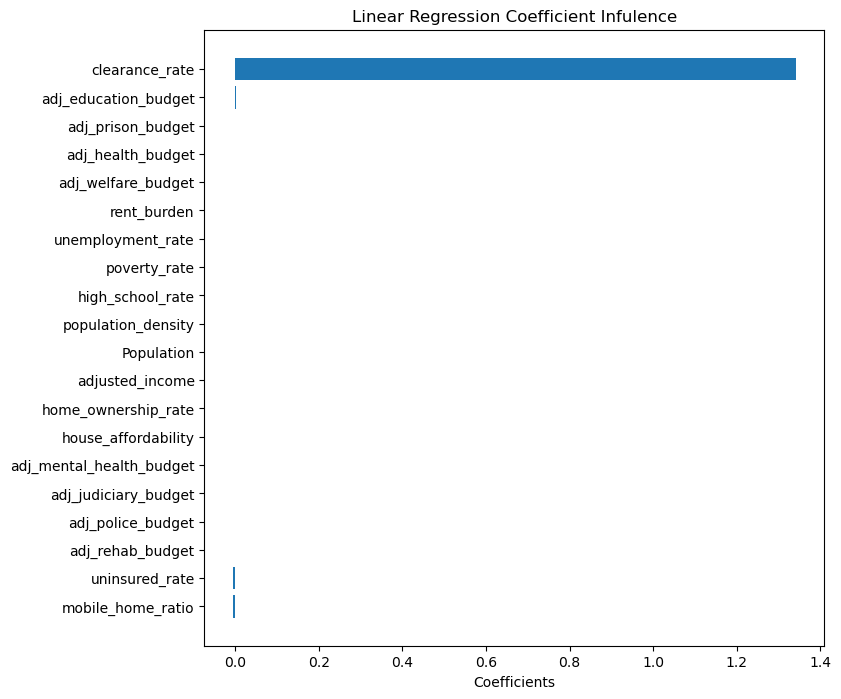

In [35]:
coeffs_mlr = fitted_models["mlr"].coef_
features = list(X_train.columns)
sorted_indices_mlr = np.argsort(coeffs_mlr)
plt.figure(figsize=(8, 8))
plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
plt.title("Linear Regression Coefficient Infulence")
plt.xlabel("Coefficients")
plt.show()

#### Visualize predicted vs true values for linear regression

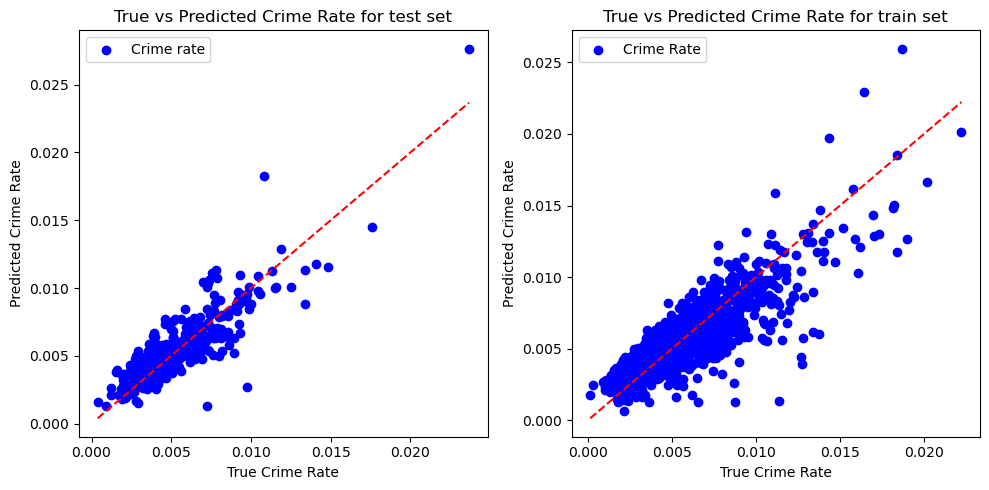

In [36]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mlr_test_preds = predicted_values["mlr"]["test"]
mlr_train_preds = predicted_values["mlr"]["train"]

# First subplot
axes[0].scatter(y_test, mlr_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, mlr_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize residuals for linear regression

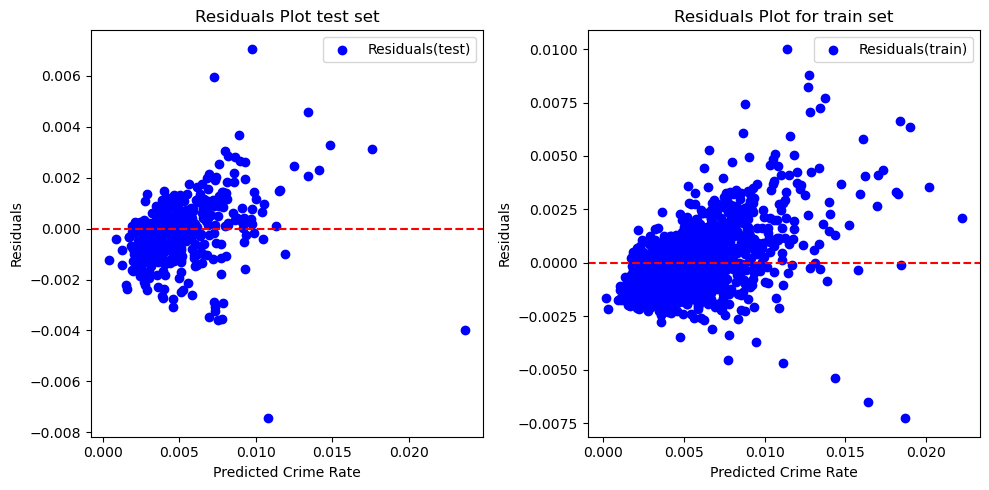

In [37]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
mlr_test_residuals = y_test - mlr_test_preds
axes[0].scatter(y_test, mlr_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
mlr_train_residuals = y_train - mlr_train_preds
axes[1].scatter(y_train, mlr_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Visualize XGB regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize feature impotance for XGBoost

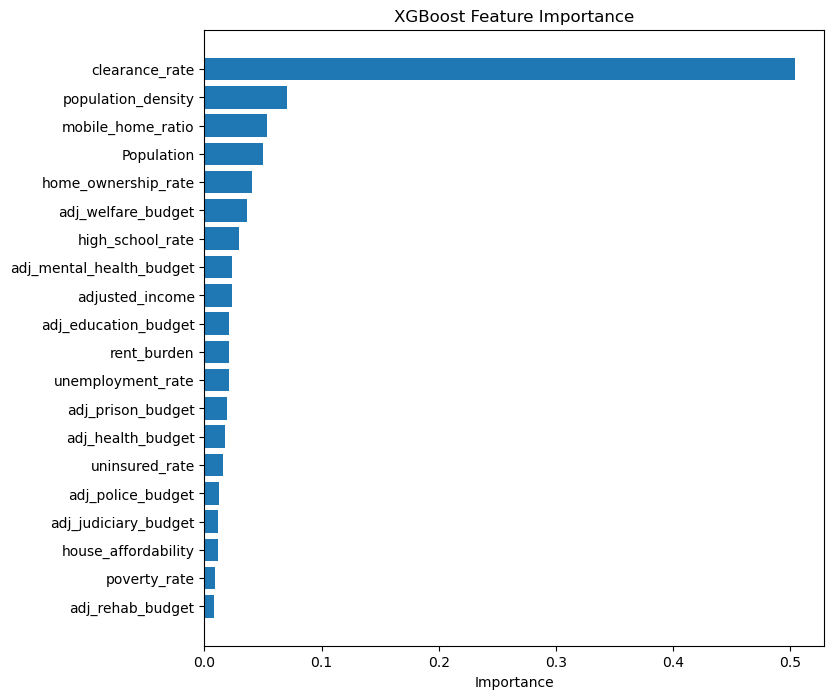

In [38]:
importance_xgb = fitted_models["xgb"].feature_importances_
sorted_indices_xgb = np.argsort(importance_xgb)
plt.figure(figsize=(8, 8))
plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

#### Visualize predicted vs true values XGBoost

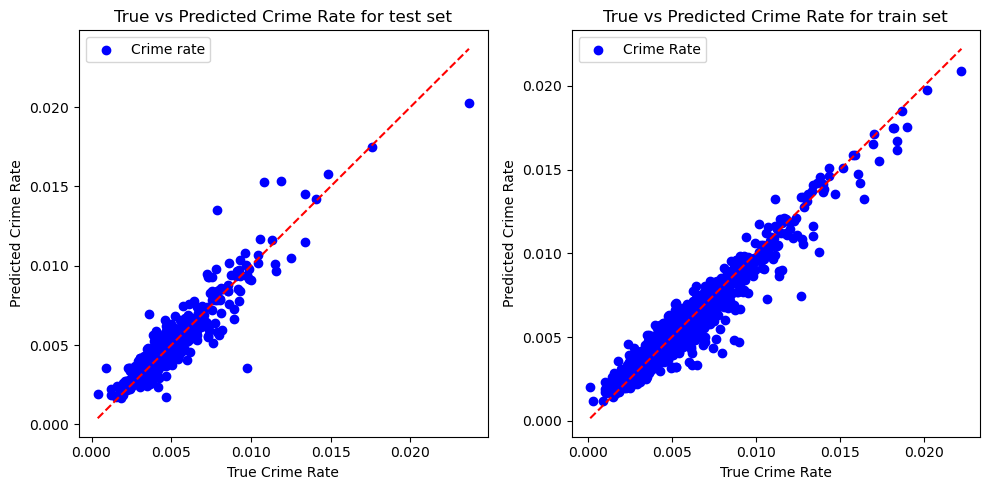

In [39]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
xgb_test_preds = predicted_values["xgb"]["test"]
xgb_train_preds = predicted_values["xgb"]["train"]

# First subplot
axes[0].scatter(y_test, xgb_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, xgb_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals XGBoost

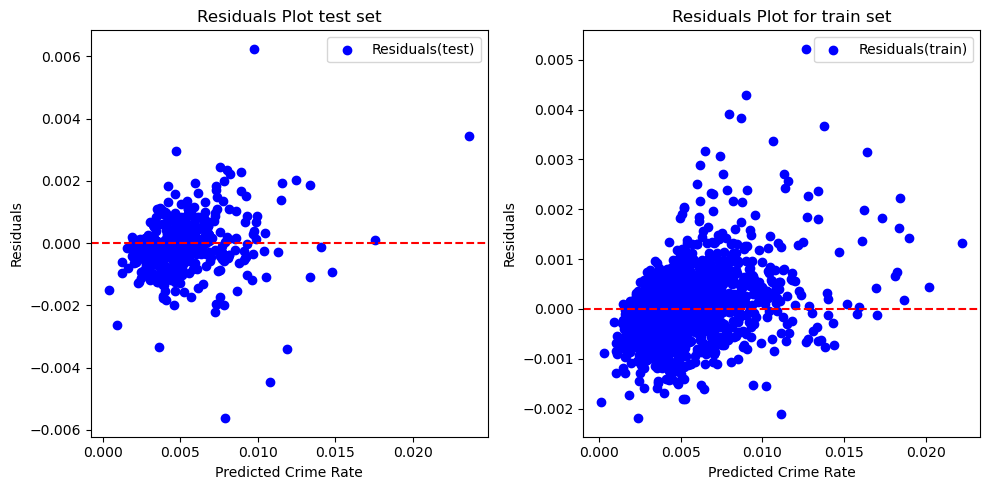

In [40]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
xgb_test_residuals = y_test - xgb_test_preds
axes[0].scatter(y_test, xgb_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
xgb_train_residuals = y_train - xgb_train_preds
axes[1].scatter(y_train, xgb_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Visualize Ridge regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize coefficient importance for Ridge regression

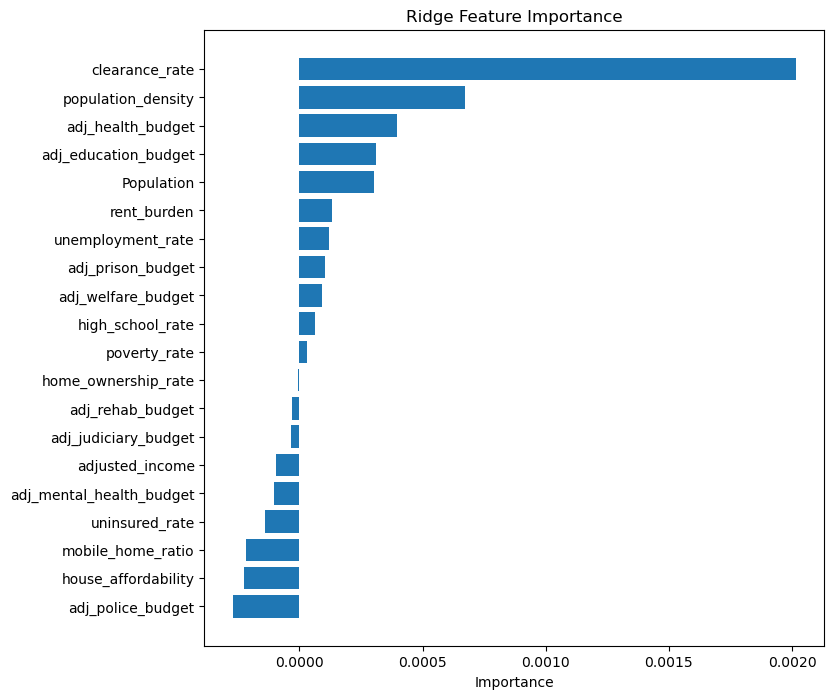

In [41]:
ridge_model = fitted_models["ridge"].named_steps["ridge"]
coeffs_ridge = ridge_model.coef_
sorted_indices_ridge = np.argsort(coeffs_ridge)
plt.figure(figsize=(8, 8))
plt.barh(
    [features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge]
)
plt.title("Ridge Feature Importance")
plt.xlabel("Importance")
plt.show()

#### Visualize predicted vs true values

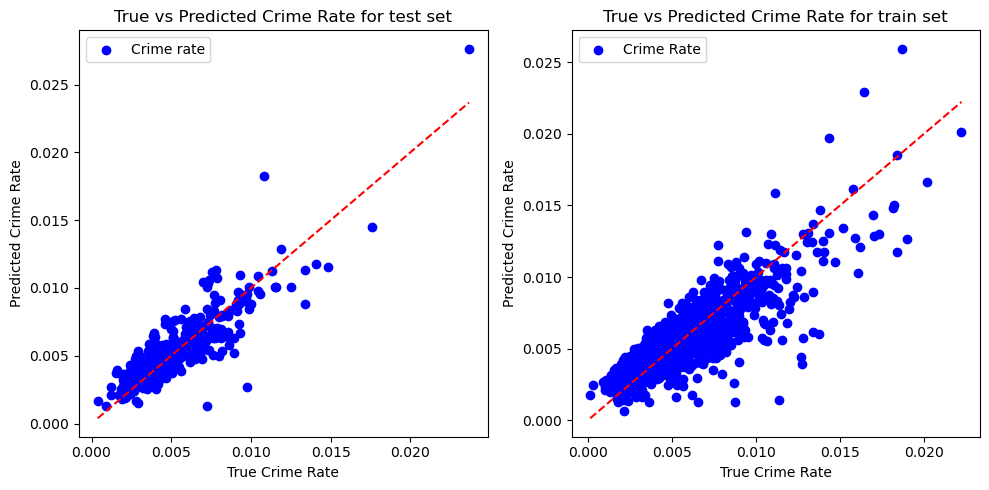

In [42]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ridge_test_preds = predicted_values["ridge"]["test"]
ridge_train_preds = predicted_values["ridge"]["train"]

# First subplot
axes[0].scatter(y_test, ridge_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, ridge_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals

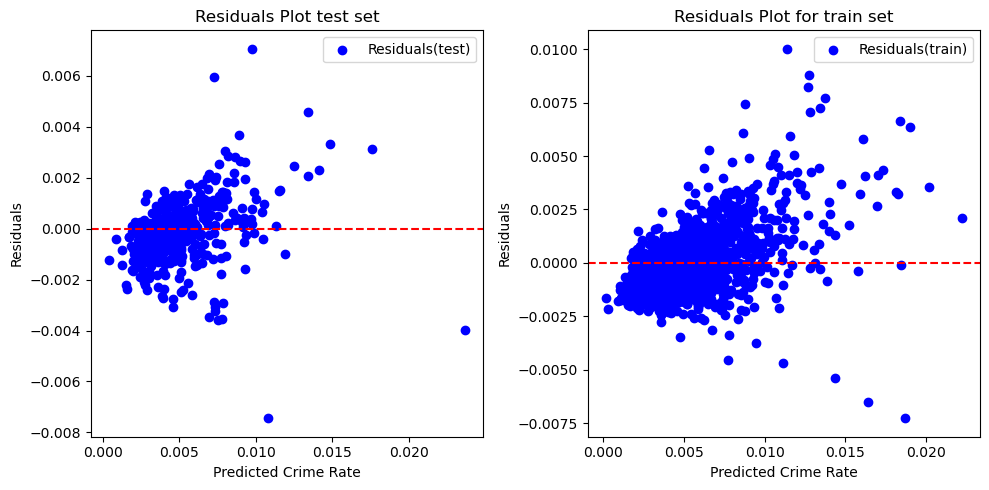

In [43]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
ridge_test_residuals = y_test - ridge_test_preds
axes[0].scatter(y_test, ridge_test_residuals, color="blue", label="Residuals(test)")
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
ridge_train_residuals = y_train - ridge_train_preds
axes[1].scatter(y_train, ridge_train_residuals, color="blue", label="Residuals(train)")
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Visualize RandomForest regression model results 
1. Visualize feature impotance
2. Visualize predicted vs true values
3. Visualize the residuals

#### Visualize coefficient importance for random forest

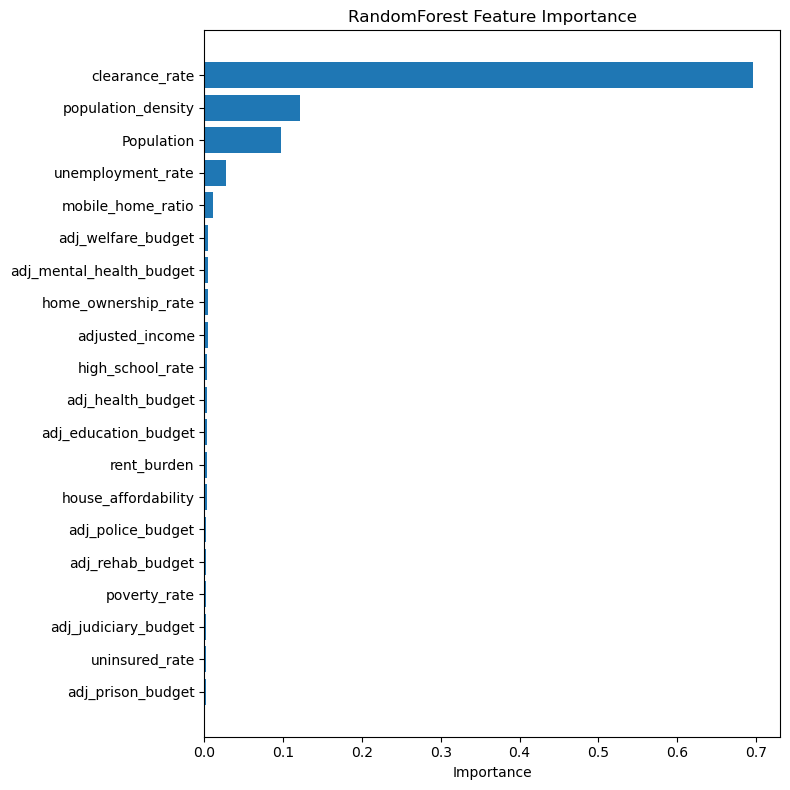

In [44]:
randonforest_model = fitted_models["random_forest"].named_steps["randomforest"]
importance_randonforest = randonforest_model.feature_importances_
sorted_indices_randonforest = np.argsort(importance_randonforest)
plt.figure(figsize=(8, 8))
plt.barh(
    [features[i] for i in sorted_indices_randonforest],
    importance_randonforest[sorted_indices_randonforest],
)
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### Visualize predicted vs true values for RandomForest

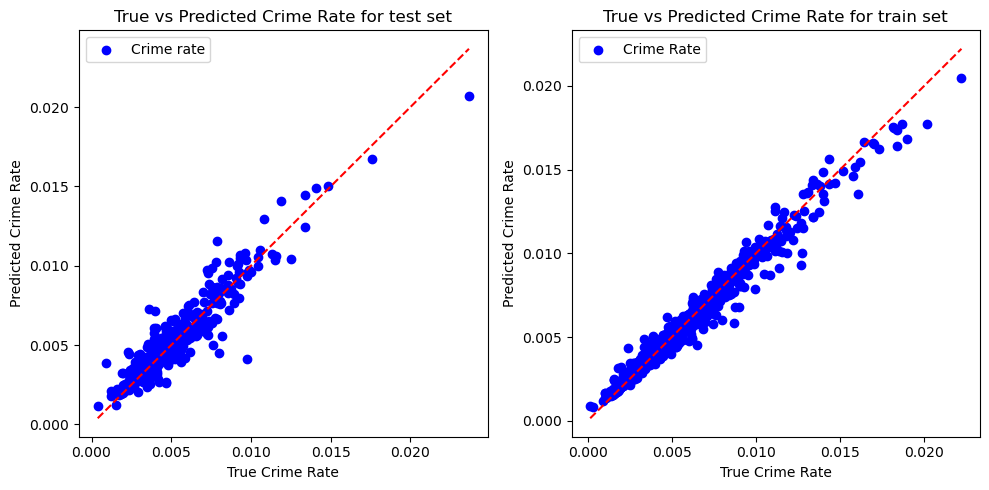

In [45]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
randomforest_test_preds = predicted_values["random_forest"]["test"]
randomforest_train_preds = predicted_values["random_forest"]["train"]

# First subplot
axes[0].scatter(y_test, randomforest_test_preds, color="blue", label="Crime rate")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
axes[0].set_title("True vs Predicted Crime Rate for test set")
axes[0].set_xlabel("True Crime Rate")
axes[0].set_ylabel("Predicted Crime Rate")
axes[0].legend()

# Second subplot
axes[1].scatter(y_train, randomforest_train_preds, color="blue", label="Crime Rate")
axes[1].plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], "--", color="red"
)
axes[1].set_title("True vs Predicted Crime Rate for train set")
axes[1].set_xlabel("True Crime Rate")
axes[1].set_ylabel("Predicted Crime Rate")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Visualize the residuals

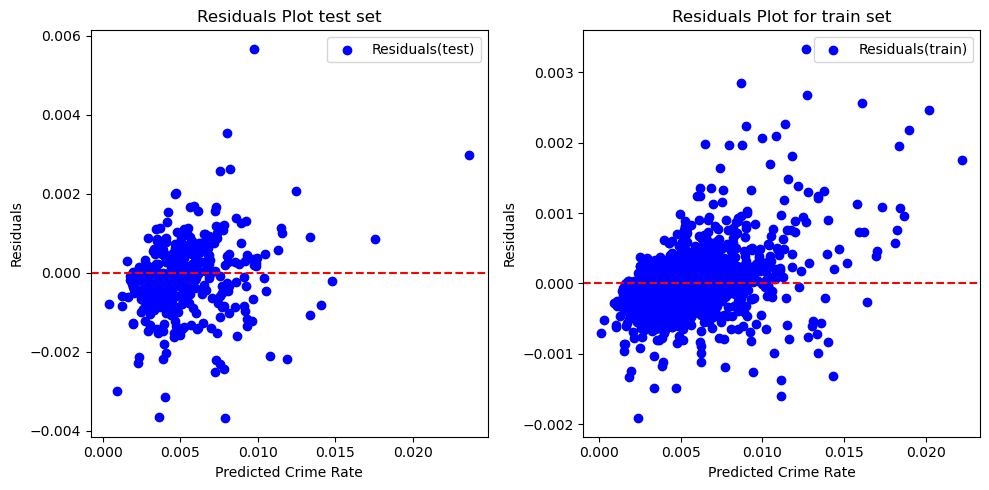

In [46]:
# Create a figure and two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
randomforest_test_residuals = y_test - randomforest_test_preds
axes[0].scatter(
    y_test, randomforest_test_residuals, color="blue", label="Residuals(test)"
)
axes[0].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[0].set_title("Residuals Plot test set")
axes[0].set_xlabel("Predicted Crime Rate")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Second subplot
randomforest_train_residuals = y_train - randomforest_train_preds
axes[1].scatter(
    y_train, randomforest_train_residuals, color="blue", label="Residuals(train)"
)
axes[1].axhline(0, color="red", linestyle="--")
# axes[0].plot([min(y_test), max(y_test)], [min(mlr_test_residuals), max(mlr_test_residuals)])
axes[1].set_title("Residuals Plot for train set")
axes[1].set_xlabel("Predicted Crime Rate")
axes[1].set_ylabel("Residuals")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Observations from the visuals.
From the visuals, it appears that the performance of the models  ranks as follows
1. Randonforest Regressor
2. XGBoost Regressor
3. Ridge Regressor
4. Linear Regressor

#### Principal Component Analysis
1. Standardise the training data: give all variables equal weight.
    - Use StandardScaler from sklearn to scale your data to have a mean of 0 and standard deviation of 
    

In [47]:
# Standardise the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Explain variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Decide the number of components to keep
# For example, keep enough components to explain 90% of variance
n_components = (
    np.argmax(cumulative_variance >= 0.9) + 1
)  # First PC where cumulative >= 90%
print(f"Number of components to retain 90% variance: {n_components}")

# Apply PCA again with the chosen number of components
pca_reduced = PCA(n_components=n_components)
X_train_reduced = pca_reduced.fit_transform(X_train_scaled)

# Show shape of reduced data
print(f"Original shape: {X_train_scaled.shape}")
print(f"Reduced shape: {X_train_reduced.shape}")

Number of components to retain 90% variance: 11
Original shape: (1809, 20)
Reduced shape: (1809, 11)


### Plot for PCA

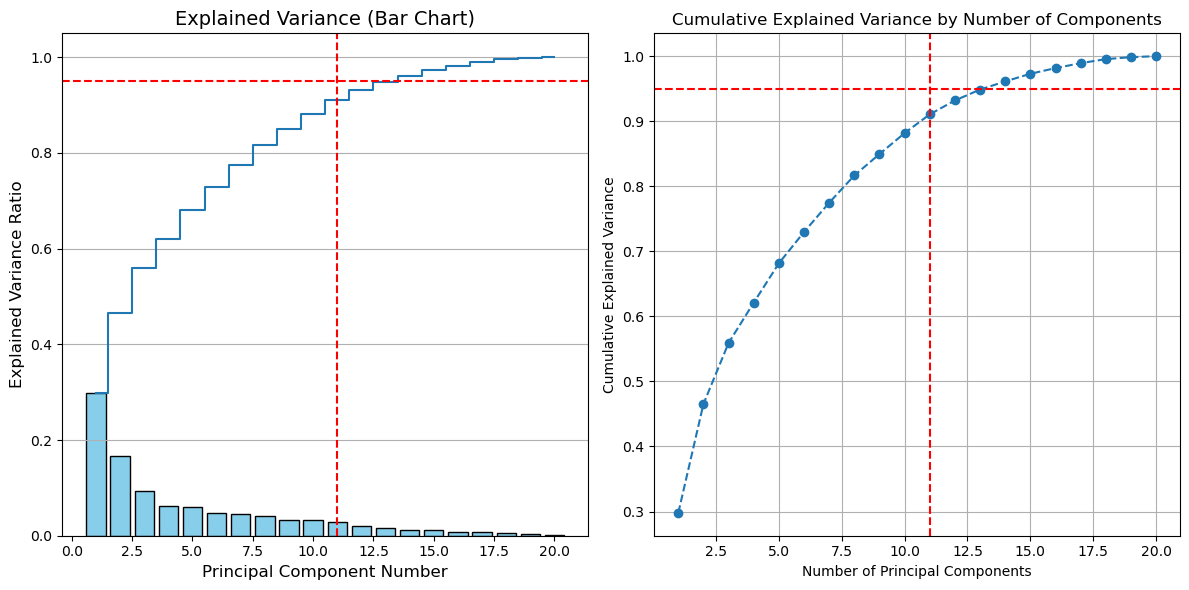

In [48]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Subplot 1: Bar chart for explained variance ratio
axes[0].bar(
    range(1, len(explained_variance) + 1),
    explained_variance,
    color="skyblue",
    edgecolor="black",
)
axes[0].step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where="mid",
    label="Cumulative Variance",
)
axes[0].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[0].axvline(x=n_components, color="red", linestyle="--", label="Retained 11 PCs")
axes[0].set_xlabel("Principal Component Number", fontsize=12)
axes[0].set_ylabel("Explained Variance Ratio", fontsize=12)
axes[0].set_title("Explained Variance (Bar Chart)", fontsize=14)
axes[0].grid(axis="y")

axes[1].plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
axes[1].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[1].axvline(x=11, color="red", linestyle="--", label="Retained 11 PCs")
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance by Number of Components")
axes[1].grid()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Interpretaion of the scree plot

- Components to the left of the elbow are important — they explain significant variance.

- Components after the elbow contribute little and may not be worth retaining.

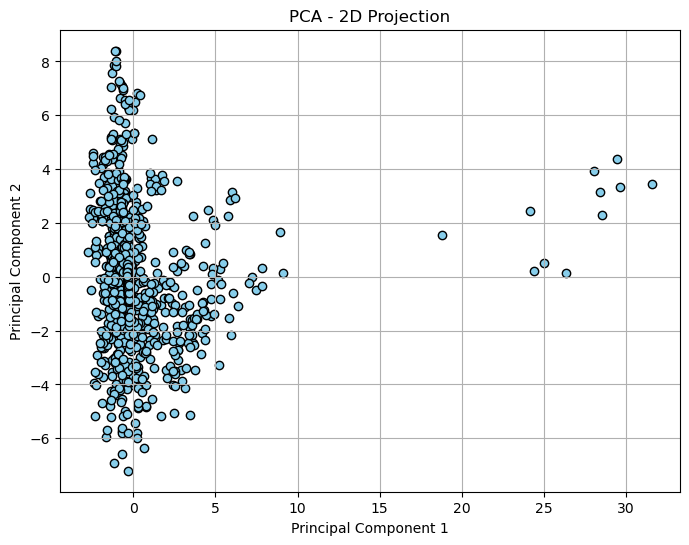

In [49]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_reduced[:, 0], X_train_reduced[:, 1], c="skyblue", edgecolor="black"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - 2D Projection")
plt.grid()
plt.show()

In [50]:
# Get the PCA loadings
loadings = pd.DataFrame(
    pca_reduced.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=X_train.columns,
)

loadings

PC1       PC2       PC3       PC4       PC5  \
Population               -0.055383  0.100636 -0.360632  0.148877  0.339294   
clearance_rate            0.014053 -0.117168  0.020826  0.282177  0.488509   
population_density       -0.036871  0.196038 -0.289765  0.370707  0.184620   
mobile_home_ratio         0.074710 -0.321451  0.274121  0.365662 -0.039796   
poverty_rate              0.020816 -0.463712 -0.202590  0.034280  0.162449   
adjusted_income          -0.067576  0.470882 -0.087933 -0.078055 -0.147088   
unemployment_rate         0.009765 -0.288587 -0.137779 -0.194994 -0.179001   
high_school_rate          0.043863  0.217432  0.330809  0.022725  0.362567   
uninsured_rate            0.003013 -0.298898 -0.400098 -0.082518 -0.298507   
house_affordability      -0.000604  0.308944 -0.289717  0.006496 -0.064091   
adj_police_budget         0.385546  0.054656 -0.061586 -0.141480  0.030049   
adj_education_budget      0.346230  0.070175 -0.110220 -0.221070  0.083379   
adj_welfare_budget        0.297306 -0.185043 -0.131475  0.033633  0.242686   
adj_mental_health_budget  0.365964  0.024169 -0.020306 -0.079298  0.110263   
adj_rehab_budget          0.351487  0.042412 -0.088803 -0.153995  0.106311   
adj_health_budget         0.386869  0.057264 -0.067527 -0.053567  0.008988   
adj_judiciary_budget      0.291692  0.045783 -0.084092  0.235859 -0.254631   
adj_prison_budget         0.249682 -0.015187  0.137877  0.497408 -0.294404   
home_ownership_rate       0.164138 -0.048060  0.460380 -0.278549  0.013879   
rent_burden              -0.210587 -0.172705 -0.071282 -0.301488  0.252667   

                               PC6       PC7       PC8       PC9      PC10  \
Population               -0.131186  0.140485  0.623875 -0.216224  0.397843   
clearance_rate            0.593618  0.344622  0.067223  0.224552 -0.327230   
population_density        0.016408 -0.359333 -0.302285  0.519989  0.364519   
mobile_home_ratio        -0.343654  0.095882 -0.037231  0.255574  0.089362   
poverty_rate             -0.124918 -0.116075 -0.157535 -0.122291 -0.051167   
adjusted_income           0.073269  0.000983  0.004142  0.084003 -0.098521   
unemployment_rate         0.439987  0.243012 -0.363853 -0.111298  0.446008   
high_school_rate         -0.146534  0.316948 -0.330984 -0.338610  0.364027   
uninsured_rate           -0.036338  0.201552  0.148391  0.187992  0.155235   
house_affordability      -0.254846  0.469349 -0.327604  0.152340 -0.076694   
adj_police_budget         0.050195 -0.021493  0.089973  0.075647  0.043106   
adj_education_budget      0.038739  0.016827 -0.009946  0.109797 -0.126578   
adj_welfare_budget       -0.165811 -0.197136 -0.175127 -0.192060 -0.062770   
adj_mental_health_budget -0.011058 -0.151133 -0.019050 -0.048715  0.025436   
adj_rehab_budget         -0.095925  0.054973 -0.046392  0.130261 -0.133645   
adj_health_budget         0.010574 -0.040991  0.015702 -0.040686  0.025840   
adj_judiciary_budget      0.029138  0.320875  0.094404 -0.085517  0.015291   
adj_prison_budget        -0.096010  0.152428  0.043684 -0.058052 -0.100393   
home_ownership_rate       0.012991  0.077970  0.254076  0.464487  0.358314   
rent_burden              -0.398189  0.299772 -0.019496  0.239627 -0.200853   

                              PC11  
Population               -0.239712  
clearance_rate           -0.027680  
population_density        0.206366  
mobile_home_ratio        -0.324011  
poverty_rate              0.132262  
adjusted_income          -0.239235  
unemployment_rate        -0.331160  
high_school_rate          0.350816  
uninsured_rate            0.304133  
house_affordability      -0.310270  
adj_police_budget         0.106353  
adj_education_budget      0.074485  
adj_welfare_budget       -0.285225  
adj_mental_health_budget -0.141985  
adj_rehab_budget          0.011443  
adj_health_budget        -0.024211  
adj_judiciary_budget      0.395672  
adj_prison_budget        -0.076285  
home_ownership_rate      -0.079603  
rent_burden  

### Scree and biplots
### Comparing principal components 1 & 2

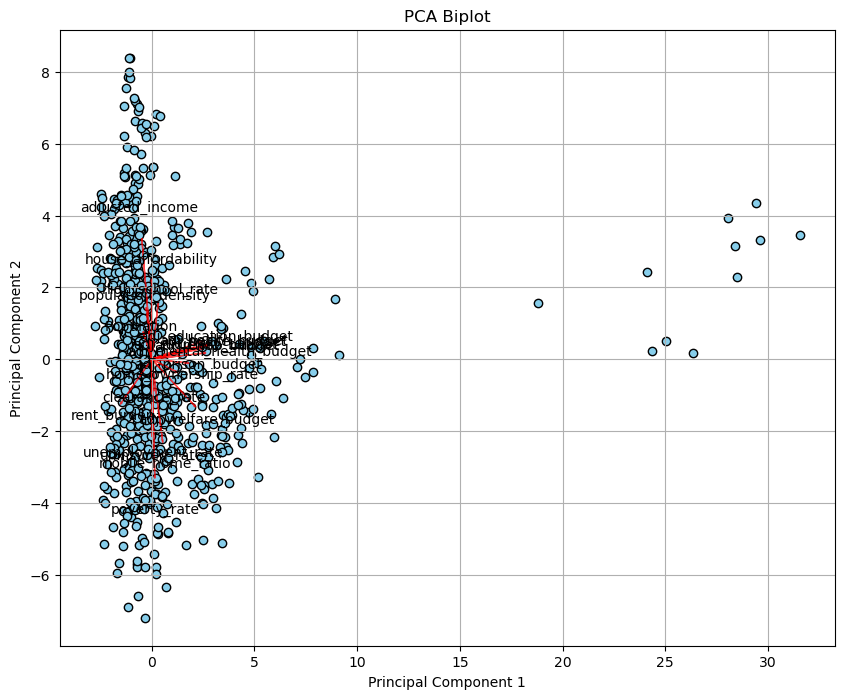

In [51]:
# Get feature loadings

# Plot biplot
plt.figure(figsize=(10, 8))

# Scatter plot of PCA scores (observations)
plt.scatter(
    X_train_reduced[:, 0], X_train_reduced[:, 1], c="skyblue", edgecolor="black"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Biplot")

# Add arrows for feature loadings (scaled for visibility)
scale_factor = 7
for i, feature in enumerate(X_train.columns):
    plt.arrow(
        0,
        0,
        loadings["PC1"].iloc[i] * scale_factor,
        loadings[f"PC2"].iloc[i] * scale_factor,
        color="red",
        alpha=0.7,
        head_width=0.05,
    )
    plt.text(
        loadings["PC1"].iloc[i] * (scale_factor + 2),
        loadings["PC2"].iloc[i] * (scale_factor + 2),
        feature,
        color="black",
        ha="center",
        va="center",
    )

plt.grid()
plt.show()

In [52]:
import numpy as np
import plotly.graph_objects as go

# `loadings` is PCA.components_.T
scaling_factor = 2
fig = go.Figure()

# Add loadings for top 3 PCs
for i, feature in enumerate(X_train.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings["PC1"].iloc[i] * scaling_factor],
            y=[0, loadings["PC2"].iloc[i] * scaling_factor],
            z=[0, loadings["PC3"].iloc[i] * scaling_factor],
            mode="lines+text",
            line=dict(color="red", width=2),
            text=[None, feature],
            name=feature,
        )
    )

# Update the layout
fig.update_layout(
    title="Loadings for Top 3 PCs",
    scene=dict(xaxis_title="PC1(x)", yaxis_title="PC2(y)", zaxis_title="PC3(z)"),
)
fig.show()

### Cross Validatons

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Define the models with pipelines
num_splits = 5
models = {
    "LinearRegression + Scaling": Pipeline(
        [("scale", StandardScaler()), ("reg", LinearRegression())]
    ),
    "XGBoost": xgb.XGBRegressor(
        random_state=42
    ),  # No scaling needed for tree-based models
    "Ridge + Scaling": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "PCA + LinearRegression": Pipeline(
        [
            ("scale", StandardScaler()),
            (
                "pca",
                PCA(n_components=n_components),
            ),
            ("reg", LinearRegression()),
        ]
    ),
    "RandomForest": Pipeline(
        [
            ("scale", StandardScaler()),  # Optional, can be omitted for tree models
            ("forest", RandomForestRegressor(random_state=42)),
        ]
    ),
}

# Training and evaluation loop
rmses = np.zeros((len(models), num_splits))
mses = np.zeros((len(models), num_splits))
r2_scores = np.zeros((len(models), num_splits))

kfold = KFold(n_splits=num_splits, random_state=42, shuffle=True)
i = 0

for train_index, test_index in kfold.split(X_train):
    X_tt, y_tt = X_train.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train.iloc[test_index], y_train.iloc[test_index]

    model_index = 0
    for model_name, model in models.items():
        model.fit(X_tt[features], y_tt)
        predictions = model.predict(X_ho[features])

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_ho, predictions))
        mse = mean_squared_error(y_ho, predictions)
        r2 = r2_score(y_ho, predictions)

        rmses[model_index, i] = rmse
        mses[model_index, i] = mse
        r2_scores[model_index, i] = r2

        # print(f"Fold {i+1}, Model {model_name}: RMSE={rmse:.4f}, MSE={mse:.4f}, R^2={r2:.4f}")
        model_index += 1

    i += 1

In [54]:
from prettytable import PrettyTable

# Create a PrettyTable
table = PrettyTable()
table.field_names = [
    "Model",
    "Mean RMSE",
    "Std RMSE",
    "Mean MSE",
    "Std MSE",
    "Mean R²",
    "Std R²",
]

# Add rows with model metrics
for model_index, model_name in enumerate(models.keys()):
    table.add_row(
        [
            model_name,
            f"{rmses[model_index].mean():.6f}",
            f"{rmses[model_index].std():.6f}",
            f"{mses[model_index].mean():.6f}",
            f"{mses[model_index].std():.6f}",
            f"{r2_scores[model_index].mean():.6f}",
            f"{r2_scores[model_index].std():.6f}",
        ],
        divider=True,
    )

table.title = "Cross-Validation: Model Performance Metrics"
table.set_style(TableStyle.DOUBLE_BORDER)
print(table)

╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
║                          Cross-Validation: Model Performance Metrics                          ║
╠════════════════════════════╦═══════════╦══════════╦══════════╦══════════╦══════════╦══════════╣
║           Model            ║ Mean RMSE ║ Std RMSE ║ Mean MSE ║ Std MSE  ║ Mean R²  ║  Std R²  ║
╠════════════════════════════╬═══════════╬══════════╬══════════╬══════════╬══════════╬══════════╣
║ LinearRegression + Scaling ║  0.001409 ║ 0.000076 ║ 0.000002 ║ 0.000000 ║ 0.716193 ║ 0.030306 ║
╠════════════════════════════╬═══════════╬══════════╬══════════╬══════════╬══════════╬══════════╣
║          XGBoost           ║  0.001146 ║ 0.000069 ║ 0.000001 ║ 0.000000 ║ 0.812100 ║ 0.022243 ║
╠════════════════════════════╬═══════════╬══════════╬══════════╬══════════╬══════════╬══════════╣
║      Ridge + Scaling       ║  0.001409 ║ 0.000076 ║ 0.000002 ║ 0.000000 ║ 0.716230 ║ 0.030350 ║
╠═══════════════════

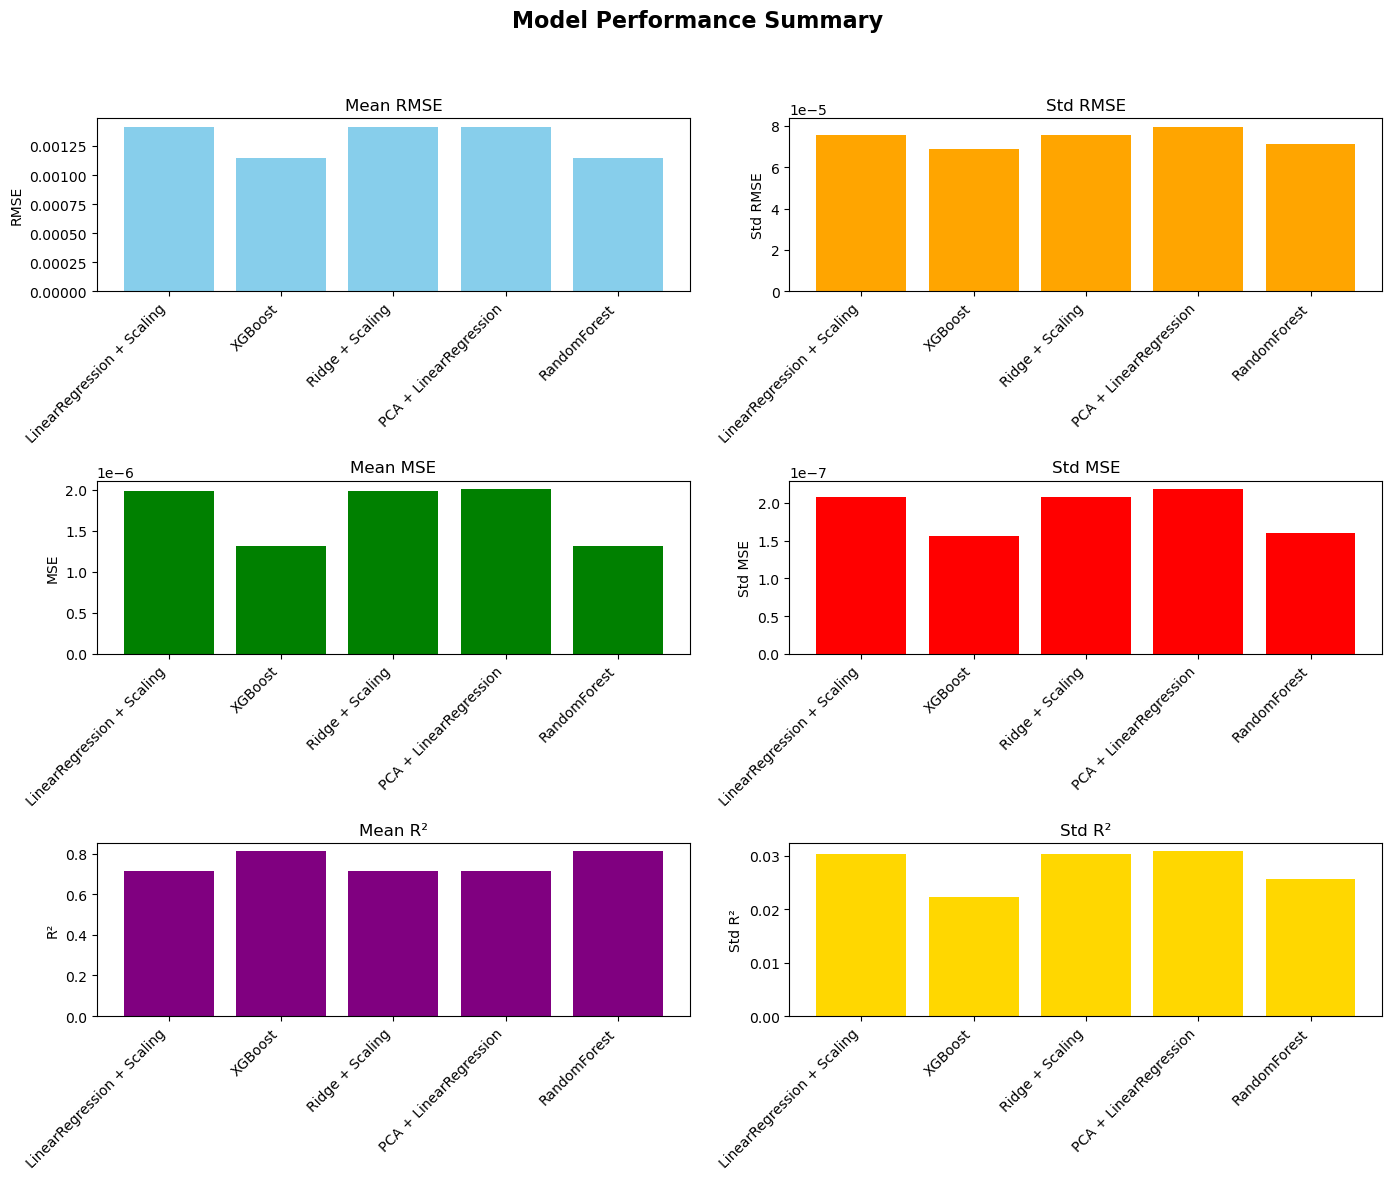

In [55]:
import matplotlib.pyplot as plt

# Subplot structure (3x2 for the 6 metrics)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Model Performance Summary", fontsize=16, fontweight="bold")

# Plot Mean RMSE
axes[0, 0].bar(
    models.keys(),
    [rmses[model_index].mean() for model_index in range(len(models))],
    color="skyblue",
)
axes[0, 0].set_title("Mean RMSE")
axes[0, 0].set_ylabel("RMSE")
axes[0, 0].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Std RMSE
axes[0, 1].bar(
    models.keys(),
    [rmses[model_index].std() for model_index in range(len(models))],
    color="orange",
)
axes[0, 1].set_title("Std RMSE")
axes[0, 1].set_ylabel("Std RMSE")
axes[0, 1].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Mean MSE
axes[1, 0].bar(
    models.keys(),
    [mses[model_index].mean() for model_index in range(len(models))],
    color="green",
)
axes[1, 0].set_title("Mean MSE")
axes[1, 0].set_ylabel("MSE")
axes[1, 0].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Std MSE
axes[1, 1].bar(
    models.keys(),
    [mses[model_index].std() for model_index in range(len(models))],
    color="red",
)
axes[1, 1].set_title("Std MSE")
axes[1, 1].set_ylabel("Std MSE")
axes[1, 1].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Mean R²
axes[2, 0].bar(
    models.keys(),
    [r2_scores[model_index].mean() for model_index in range(len(models))],
    color="purple",
)
axes[2, 0].set_title("Mean R²")
axes[2, 0].set_ylabel("R²")
axes[2, 0].set_xticklabels(models.keys(), rotation=45, ha="right")

# Plot Std R²
axes[2, 1].bar(
    models.keys(),
    [r2_scores[model_index].std() for model_index in range(len(models))],
    color="gold",
)
axes[2, 1].set_title("Std R²")
axes[2, 1].set_ylabel("Std R²")
axes[2, 1].set_xticklabels(models.keys(), rotation=45, ha="right")

# Adjust layout for better spacing and readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Show the plots
plt.show()